In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mesa_reader as mr
import sys
import os
import math
from pandas import DataFrame, read_csv
from scipy.optimize import curve_fit
from scipy.integrate import quad, romb
from scipy import integrate
%matplotlib inline

history_data = pd.read_csv('LOGS/history.data', encoding = 'utf-8', delimiter=r'\s+', skiprows=5)
print(history_data.shape)

v_star = 304852.9700254425

#history_data['n(h1)*r^2'].describe()
#history_data['n(h1)*r^2'].head()

(2562, 66)


# Constants

In [2]:
h_bar     = 1.055e-34
G         = 6.67e-11          # Gravitational Constant
m_p       = 1.6726219e-27     # Mass of proton
M_sun     = 1.989e30          # Mass of the sun
R_sun     = 696340000         # Radius of the sun
ly        = 9.4607e15         # Light Year
Gev_c2    = (1e9 * 1.6 * 1e-19 ) / (9*1e16)
parsec    = 3.0857e16         # Parsec
AU        = 150 * 1e6 * 1e3   # Astronimical unit
M_sun_pc3 = M_sun/(parsec**3)

m_n_h1      = 0.9387597 * Gev_c2
m_n_he4     = 3.7284    * Gev_c2
m_n_c12     = 11.269585 * Gev_c2
m_n_n14     = 13.047    * Gev_c2
m_n_o16     = 15.011    * Gev_c2
m_n_ne20    = 18.93     * Gev_c2
m_n_mg24    = 22.805    * Gev_c2

A_n_h1   = 1
A_n_he4  = 2
A_n_c12  = 6
A_n_n14  = 7
A_n_o16  = 8
A_n_ne20 = 10
A_n_mg24 = 12

# Stellar Parameters

In [3]:
M_star    = 5.0 * M_sun
R_star    = 55.91235875 * R_sun
m_x       = 100 * Gev_c2
#rho_x    = 1000 * M_sun_pc3
rho_x     = 1000 * Gev_c2 * 1e6
v_esca    = np.sqrt((2*G*M_star)/(R_star))
v_ave_x   = 270000
#v_star    = 684.1565430795765
sigma_SI  = 1e-48
sigma_SD  = 1e-42

# Calculated Constant Parameters

In [4]:
mu_h1   = m_x / m_n_h1
mu_he4  = m_x / m_n_he4
mu_c12  = m_x / m_n_c12
mu_n14  = m_x / m_n_n14
mu_o16  = m_x / m_n_o16
mu_ne20 = m_x / m_n_ne20
mu_mg24 = m_x / m_n_mg24

mu_nega_h1   = (mu_h1   - 1) / 2
mu_nega_he4  = (mu_he4  - 1) / 2
mu_nega_c12  = (mu_c12  - 1) / 2
mu_nega_n14  = (mu_n14  - 1) / 2
mu_nega_o16  = (mu_o16  - 1) / 2
mu_nega_ne20 = (mu_ne20 - 1) / 2
mu_nega_mg24 = (mu_mg24 - 1) / 2

mu_posi_h1   = (mu_h1   - 1) / 2
mu_posi_he4  = (mu_he4  - 1) / 2
mu_posi_c12  = (mu_c12  - 1) / 2
mu_posi_n14  = (mu_n14  - 1) / 2
mu_posi_o16  = (mu_o16  - 1) / 2
mu_posi_ne20 = (mu_ne20 - 1) / 2
mu_posi_mg24 = (mu_mg24 - 1) / 2

u_max_h1   = (v_esca * np.sqrt(mu_h1))   / mu_nega_h1
u_max_he4  = (v_esca * np.sqrt(mu_he4))  / mu_nega_he4
u_max_c12  = (v_esca * np.sqrt(mu_c12))  / mu_nega_c12
u_max_n14  = (v_esca * np.sqrt(mu_n14))  / mu_nega_n14
u_max_o16  = (v_esca * np.sqrt(mu_o16))  / mu_nega_o16
u_max_ne20 = (v_esca * np.sqrt(mu_ne20)) / mu_nega_ne20
u_max_mg24 = (v_esca * np.sqrt(mu_mg24)) / mu_nega_mg24

R_0_he4 = ((0.91*((m_n_he4/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_he4 = (3*(h_bar**2)) / (2*(m_n_he4)*R_0_he4)

R_0_c12 = ((0.91*((m_n_c12/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_c12 = (3*(h_bar**2)) / (2*(m_n_c12)*R_0_c12)

R_0_n14 = ((0.91*((m_n_n14/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_n14 = (3*(h_bar**2)) / (2*(m_n_n14)*R_0_n14)

R_0_o16 = ((0.91*((m_n_o16/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_o16 = (3*(h_bar**2)) / (2*(m_n_o16)*R_0_o16)

R_0_ne20 = ((0.91*((m_n_ne20/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_ne20 = (3*(h_bar**2)) / (2*(m_n_ne20)*R_0_ne20)

R_0_mg24 = ((0.91*((m_n_mg24/Gev_c2)**0.3333)+0.3)*1e-15)**2
E_0_mg24 = (3*(h_bar**2)) / (2*(m_n_mg24)*R_0_mg24)

# H-R Diagram

Text(0.5, 1.0, 'H-R Diagram')

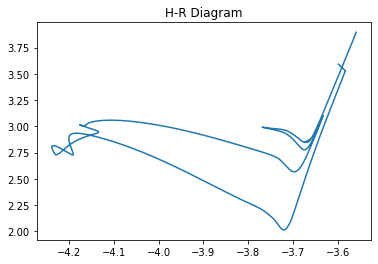

In [5]:
log_Teff = pd.DataFrame(history_data, columns= ['log_Teff'])
log_L    = pd.DataFrame(history_data, columns= ['log_L'])

plt.plot(-log_Teff,log_L)
plt.title("H-R Diagram")
#plt.savefig("H-R Diagram.eps", dpi=300)

# Part 1-4 h1 Capture Rate Calculations

In [6]:
part_1_h1 = 4 * np.sqrt(6*np.pi) * (rho_x/m_x) * (1/(v_ave_x*v_star)) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_h1 = sigma_SI + sigma_SD

part_3_h1   = (history_data['n(h1)*r^2'].values)

def f_h1(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) * np.sinh((3*u*v_star)/(v_ave_x**2)) \
    * (v_esca**2 - (((mu_nega_h1**2)*(u**2))/mu_h1))

part_44_h1  = quad(f_h1, 0, u_max_h1)
part_4_h1   = part_44_h1[0]

cap_rate_h1 = part_1_h1 * part_2_h1 * part_3_h1 * part_4_h1
print('cap_rate_h1 = ', cap_rate_h1)

cap_rate_h1 =  [2.91292204e+25 2.91292204e+25 2.91292203e+25 ... 2.34088185e+25
 2.34090788e+25 2.34090132e+25]


# Part 1-4 He4 Capture Rate Calculations

In [7]:
part_1_he4 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_he4/(v_ave_x*v_star)) \
            * ((mu_posi_he4**2) / mu_he4 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_he4 = sigma_SI * (A_n_he4**2) * ((m_x*m_n_he4)/(m_x+m_n_he4))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_he4  = (history_data['n(he4)*r^2'].values)

def f_he4(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_he4)) \
              - np.exp((-m_x*(u**2)*mu_he4)/(2*E_0_he4*mu_posi_he4)) \
              * np.exp(((-m_x*(v_esca**2)*mu_he4)/(2*E_0_he4*(mu_nega_he4**2)))-(1-mu_he4/(mu_posi_he4**2))))

part_44_he4 = quad(f_he4, 0, u_max_he4)
part_4_he4  = part_44_he4[0]

cap_rate_he4 = part_1_he4 * part_2_he4 * part_3_he4 * part_4_he4
print('cap_rate_he4 = ', cap_rate_he4)

cap_rate_he4 =  [1.47867845e+24 1.47867845e+24 1.47867845e+24 ... 1.51631656e+24
 1.51606952e+24 1.51592519e+24]


# part 1-4 C12 Capture Rate Calculations

In [8]:
part_1_c12 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_c12/(v_ave_x*v_star)) \
            * ((mu_posi_c12**2) / mu_c12 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_c12 = sigma_SI * (A_n_c12**2) * ((m_x*m_n_c12)/(m_x+m_n_c12))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_c12 = (history_data['n(c12)*r^2'].values)

def f_c12(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_c12)) \
              - np.exp((-m_x*(u**2)*mu_c12)/(2*E_0_c12*mu_posi_c12)) \
              * np.exp(((-m_x*(v_esca**2)*mu_c12)/(2*E_0_c12*(mu_nega_c12**2)))-(1-mu_c12/(mu_posi_c12**2))))

part_44_c12 = quad(f_c12, 0, u_max_c12)
part_4_c12 = part_44_c12[0]

cap_rate_c12 = part_1_c12 * part_2_c12 * part_3_c12 * part_4_c12
print('cap_rate_c12 = ', cap_rate_c12)

cap_rate_c12 =  [4.94904557e+22 4.94904556e+22 4.94904555e+22 ... 9.55848924e+23
 9.56049001e+23 9.56248649e+23]


# Part 1-4 N14 Capture Rate Calculations

In [9]:
part_1_n14 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_n14/(v_ave_x*v_star)) \
            * ((mu_posi_n14**2) / mu_n14 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_n14 = sigma_SI * (A_n_n14**2) * ((m_x*m_n_n14)/(m_x+m_n_n14))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_n14 = (history_data['n(n14)*r^2'].values)

def f_n14(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_n14)) \
              - np.exp((-m_x*(u**2)*mu_n14)/(2*E_0_n14*mu_posi_n14)) \
              * np.exp(((-m_x*(v_esca**2)*mu_n14)/(2*E_0_n14*(mu_nega_n14**2)))-(1-mu_n14/(mu_posi_n14**2))))

part_44_n14 = quad(f_n14, 0, u_max_n14)
part_4_n14 = part_44_n14[0]

cap_rate_n14 = part_1_n14 * part_2_n14 * part_3_n14 * part_4_n14
print('cap_rate_n14 = ', cap_rate_n14)

cap_rate_n14 =  [1.39245599e+22 1.39245598e+22 1.39245598e+22 ... 4.09604402e+22
 4.09539110e+22 4.09484880e+22]


# Part 1-4 O16 Capture Rate Calculations

In [10]:
part_1_o16 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_o16/(v_ave_x*v_star)) \
            * ((mu_posi_o16**2) / mu_o16 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_o16 = sigma_SI * (A_n_o16**2) * ((m_x*m_n_o16)/(m_x+m_n_o16))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_o16 = (history_data['n(o16)*r^2'].values)

def f_o16(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_o16)) \
              - np.exp((-m_x*(u**2)*mu_o16)/(2*E_0_o16*mu_posi_o16)) \
              * np.exp(((-m_x*(v_esca**2)*mu_o16)/(2*E_0_o16*(mu_nega_o16**2)))-(1-mu_o16/(mu_posi_o16**2))))

part_44_o16 = quad(f_o16, 0, u_max_o16)
part_4_o16 = part_44_o16[0]

cap_rate_o16 = part_1_o16 * part_2_o16 * part_3_o16 * part_4_o16
print('cap_rate_o16 = ', cap_rate_o16)

cap_rate_o16 =  [1.00899629e+23 1.00899629e+23 1.00899629e+23 ... 8.51560328e+23
 8.51712027e+23 8.51861768e+23]


# Part 1-4 Ne20 Capture Rate Calculations

In [11]:
part_1_ne20 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_ne20/(v_ave_x*v_star)) \
            * ((mu_posi_ne20**2) / mu_ne20 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_ne20 = sigma_SI * (A_n_ne20**2) * ((m_x*m_n_ne20)/(m_x+m_n_ne20))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_ne20 = (history_data['n(ne20)*r^2'].values)

def f_ne20(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_ne20)) \
              - np.exp((-m_x*(u**2)*mu_ne20)/(2*E_0_ne20*mu_posi_ne20)) \
              * np.exp(((-m_x*(v_esca**2)*mu_ne20)/(2*E_0_ne20*(mu_nega_ne20**2)))-(1-mu_ne20/(mu_posi_ne20**2))))

part_44_ne20 = quad(f_ne20, 0, u_max_ne20)
part_4_ne20 = part_44_ne20[0]

cap_rate_ne20 = part_1_ne20 * part_2_ne20 * part_3_ne20 * part_4_ne20
print('cap_rate_ne20 = ', cap_rate_ne20)

cap_rate_ne20 =  [-9.60790126e+21 -9.60790124e+21 -9.60790122e+21 ... -2.02346657e+22
 -2.02360273e+22 -2.02386550e+22]


# Part 1-4 Mg24 Capture Rate Calculations

In [12]:
part_1_mg24 = 8 * np.sqrt(6*np.pi) * (rho_x/(m_x**2)) * (E_0_mg24/(v_ave_x*v_star)) \
            * ((mu_posi_mg24**2) / mu_mg24 ) \
            * np.exp((-3*(v_star**2))/(2*(v_ave_x**2)) )

part_2_mg24 = sigma_SI * (A_n_mg24**2) * ((m_x*m_n_mg24)/(m_x+m_n_mg24))**2 \
             * ((m_x+m_p)/(m_x*m_p))**2

part_3_mg24 = (history_data['n(mg24)*r^2'].values)

def f_mg24(u):
    return np.exp((-3*(u**2))/(2*(v_ave_x**2))) \
           * np.sinh((3*u*v_star)/(v_ave_x**2)) \
           * (np.exp((-m_x*(u**2))/(2*E_0_mg24)) \
              - np.exp((-m_x*(u**2)*mu_mg24)/(2*E_0_mg24*mu_posi_mg24)) \
              * np.exp(((-m_x*(v_esca**2)*mu_mg24)/(2*E_0_mg24*(mu_nega_mg24**2)))-(1-mu_mg24/(mu_posi_mg24**2))))

part_44_mg24 = quad(f_mg24, 0, u_max_mg24)
part_4_mg24 = part_44_mg24[0]

cap_rate_mg24 = part_1_mg24 * part_2_mg24 * part_3_mg24 * part_4_mg24
print('cap_rate_mg24 = ', cap_rate_mg24)

cap_rate_mg24 =  [-1.53870196e+23 -1.53870195e+23 -1.53870195e+23 ... -1.40653166e+23
 -1.40651389e+23 -1.40651247e+23]


# Total Capture Rate

[2.64063061e+25 2.64062218e+25 2.64061765e+25]


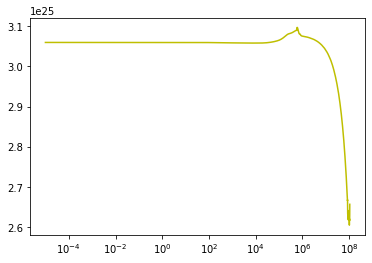

In [13]:
Total_C_R = cap_rate_h1 + cap_rate_he4 + cap_rate_c12 + cap_rate_o16 + cap_rate_ne20 + cap_rate_mg24

plt.xscale('log')
#plt.plot(history_data['star_age'].values, cap_rate_h1, 'r')
#plt.plot(history_data['star_age'].values, cap_rate_he4,'g')
#plt.plot(history_data['star_age'].values, cap_rate_c12,'b')

print(Total_C_R[1462:1465])
plt.plot(history_data['star_age'].values, Total_C_R,'y')

# When star Reaches to Zero Age Main-Sequence (ZAMS)

In [14]:
L_h1  = history_data['log_LH'].values
L_he4 = history_data['log_LHe'].values
L_Z = history_data['log_LZ'].values
L_total = history_data['log_Lnuc'].values

h1_luminosity_fraction = (10**L_h1) / (10**L_total)

#plt.xscale('log')
#plt.plot(history_data['star_age'].values, h1_luminosity_fraction)
#plt.title("ZAMS")

print(100*h1_luminosity_fraction[1462:1465]-99.9)
#print(history_data['star_age'].values[1460:1470])
star_radius = 10**history_data['log_R'].values
print(star_radius[1462:1465])

[0.0618288  0.05519302 0.04739681]
[55.5810154  55.91235875 56.22747526]


# When star Reaches to Intermediate Age Main-Sequence (IAMS)

In [15]:
h1  = history_data['total_mass_h1'].values
he4 = history_data['total_mass_he4'].values
h1_fraction = (h1) #/ (h1+he4)

#plt.xscale('log')
#plt.xlim([1.2*1e11,2*1e11])
#plt.ylim([0,1])
#plt.plot(history_data['star_age'].values, h1_fraction)
#plt.title("IAMS")

# Regression to Capture-Rate

In [16]:
def bpm(t,c0,c1,c2,c3,c4,c5,c6,c7,c8):
    return c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5 + c6*t**6 + c7*t**7 + c8*t**8

g = [-1,-1,-1,-1,-1,-1,-1,-1,-1]

n = len(history_data['star_age'])
y = np.empty(n)
t = history_data['star_age']

Total_C_R_b = Total_C_R / 1e22
c,cov = curve_fit(bpm,t,Total_C_R_b,g)
print(c)

for i in range(n):
    y[i] = bpm(history_data['star_age'][i],c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8])
    
#plt.xscale('log')
#plt.ylim([0.9,1.1])
#plt.xlim([1e3,1e8])
#plt.plot(t,y,'r-')

[ 3.06542417e+03  2.37260564e-05 -3.92955274e-12  2.17425151e-19
 -6.18466028e-27  9.94640581e-35 -9.17944444e-43  4.54169360e-51
 -9.33471740e-60]


In [17]:
from sklearn.metrics import r2_score
print('R^2 :', r2_score(y,Total_C_R_b))

R^2 : 0.9966790863851592


In [18]:
print(Total_C_R[1462:1465])

[2.64063061e+25 2.64062218e+25 2.64061765e+25]
